### Document to Text with Space between Words
form: pandas data frame

In [1]:
import re

import pandas as pd
import spacy

In [2]:
nlp = spacy.load('ja_ginza')

In [3]:
D_path = './corpus2/'
topics = ['Gourmet', 'Keitai', 'Kyoto', 'Sports']

In [4]:
cols = ['doc', 'label']
df = pd.DataFrame(index=[], columns=cols)
regex = re.compile(r'(［.*］)(.*)')

for topic in topics:
    data = pd.read_table(D_path + topic + '.tsv', header = None, dtype = str, usecols = [1])
    for d in data.itertuples():
        m = regex.match(d[1])
        # first line of the docment
        if m != None:
            if d[0] != 0:
                df = df.append(pd.DataFrame([doc.strip(), topic], index = cols).T)
            sent = m.groups()[1]
            doc = ''
        else:
            sent = d[1]
        doc = doc+' ' + ' '.join([t.text for t in nlp(sent) \
                                  if (t.pos_ != 'ADP'  and t.pos_ != 'AUX' and t.pos_ != 'PUNCT')])
    df = df.append(pd.DataFrame([doc.strip(), topic], index = cols).T)

In [5]:
df[:3]

,doc,label
0,烏丸 六角 おかき 屋 さん 六角堂 前 ある 蕪村 庵 いう お店 行っ て おかき せん...,Gourmet
0,河原町 居酒屋 この 間 先輩 たち つれ 河原町 居酒屋 行っ て き ｈｔｔｐ：／／ｗｗ...,Gourmet
0,ちょっと 贅沢 ほんの ちょこっと ん けど 贅沢 とき 何 か 私 冬季 限定 白バラ コ...,Gourmet


In [6]:
df.shape

(249, 2)

In [7]:
df['label'].value_counts(sort = False)

Kyoto      91
Gourmet    57
Sports     22
Keitai     79
Name: label, dtype: int64

#### DataFrame to CSV

In [8]:
df.to_csv('corpus2/split_data.csv')

In [9]:
df = pd.read_csv('corpus2/split_data.csv')

### Document Classification

In [42]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

#### split data

In [43]:
train_X, test_X, train_y, test_y = train_test_split(
    df['doc'], df['label'], test_size = 0.2, random_state = 0, stratify = df['label'])
print(f'''
train_X: {train_X.shape}
test_X: {test_X.shape}
train_y: {train_y.shape}
test_y: {test_y.shape}
''')
print(train_y.value_counts())
print(test_y.value_counts())


train_X: (199,)
test_X: (50,)
train_y: (199,)
test_y: (50,)

Kyoto      73
Keitai     63
Gourmet    45
Sports     18
Name: label, dtype: int64
Kyoto      18
Keitai     16
Gourmet    12
Sports      4
Name: label, dtype: int64


#### evaluation tools

In [44]:
def conf_mat(true_y, pred_y, labels):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    plt.rcParams['figure.figsize'] = (4.0, 4.0)
    mat = confusion_matrix(true_y, pred_y)
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
               xticklabels = labels, yticklabels = labels)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

#### Bag of Words

In [45]:
cv = CV(token_pattern = '(?u)\\b\\w+\\b')
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w+\\b',
                tokenizer=None, vocabulary=None)

#### Naive Bayes

train accuracy = 1.0
test accuracy = 0.92


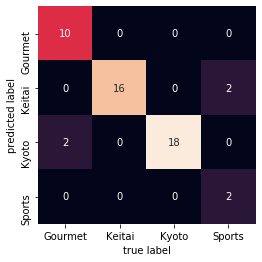

In [46]:
nb_clf = MultinomialNB(alpha=0.1)
nb_model = make_pipeline(cv, nb_clf)

nb_model.fit(train_X, train_y)

train_acc = nb_model.score(train_X, train_y)
test_acc = nb_model.score(test_X, test_y)
pred_y = nb_model.predict(test_X)

print(f'train accuracy = {train_acc}')
print(f'test accuracy = {test_acc}')
conf_mat(test_y, pred_y, topics)

#### Logistic Regression

train accuracy = 1.0
test accuracy = 0.88


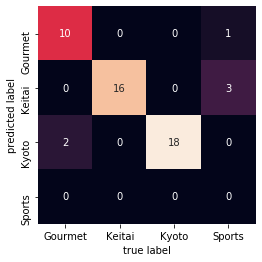

In [47]:
import warnings
warnings.filterwarnings('ignore')

lg_clf = LogisticRegression(penalty = 'l2', random_state = 0)
lg_model=make_pipeline(cv, lg_clf)

lg_model.fit(train_X, train_y)

train_acc = lg_model.score(train_X, train_y)
test_acc = lg_model.score(test_X, test_y)
pred_y = lg_model.predict(test_X)

print(f'train accuracy = {train_acc}')
print(f'test accuracy = {test_acc}')
conf_mat(test_y, pred_y, topics)

#### Online Suport Vector Machine

train accuracy = 1.0
test accuracy = 0.86


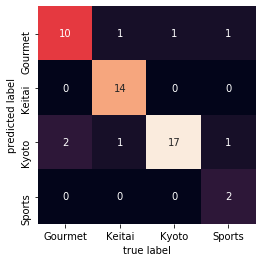

In [48]:
svm_clf = SGDClassifier(loss = 'hinge')
svm_model = make_pipeline(cv, svm_clf)

svm_model.fit(train_X, train_y)

train_acc = svm_model.score(train_X, train_y)
test_acc = svm_model.score(test_X, test_y)
pred_y = svm_model.predict(test_X)

print(f'train accuracy = {train_acc}')
print(f'test accuracy = {test_acc}')
conf_mat(test_y, pred_y, topics)

おしまーい